---

**Lesson 2** for the YT course of

[***Machine Learning for Audio Signals in Python - MLfAS***](https://github.com/GuitarsAI/MLfAS)

Original Jupyter Notebooks by [*Renato Profeta*](https://www.youtube.com/c/GuitarsAI)

---

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

device='cpu'
#device='cuda'

# Neural Network as Function Approximator, Regression

In [2]:
N=40 #number of samples in our signal
Nodes=10 #Number of Nodes in the hidden layer. This results in a smooth interpolation
#Nodes=80  #this can result in over-fitting

#A 2-layer fully connected network, 1 input (time value), hidden layer has "Nodes" nodes, 1 output (function value).

class LinNet(nn.Module):
    #define and initialize the layers:
    def __init__(self):
        super(LinNet, self).__init__()
        # Define the model. 
        #https://pytorch.org/docs/stable/nn.html?highlight=linear#torch.nn.Linear  
        # Generate a fully connected linear neural network model, 2 layers, bias
        # returns: Trainable object
        self.layer1=nn.Sequential(nn.Linear(in_features=1, out_features=Nodes, bias=True))
        self.layer2=nn.Sequential(nn.Linear(in_features=Nodes, out_features=1, bias=True))
      
        #self.act = nn.LeakyReLU() #non-linear activation function
        #self.act = nn.ReLU() #non-linear activation function
        #self.act = nn.Hardtanh() #non-linear activation function
        self.act = nn.Sigmoid() #non-linear activation function
      
    #Putting the network together:
    def forward(self, x):
        out = self.layer1(x)
        #print("out.shape=", out.shape)
        out = self.act(out)  #comment out if not desired
        #print("out.shape=", out.shape)
        out = self.layer2(out)
        #print("out.shape=", out.shape)
        return out

In [3]:
print("Number of input samples:", N, "number of nodes:", Nodes)
#input tensor, type torch tensor:
#Indices: batch, additional dimensions, features or signal dimension. Here: 1 batch, 3 samples, signal dimension 2: 
#Training set:
#The x input here is the time:
X=torch.arange(0,N,1.0) #generates N time steps for X
X=X.view(N,1) #adding the last dimension for the signal (1 sample each), first dimension for the batch of size N
print("X.shape", X.shape)
#Target here is the (noisy) function value, a sine function + normal distributed random values:
#Y=torch.sin(X)+torch.empty(X.shape).normal_(std=0.5)
Y=torch.sin(X*3.14/N*2)+torch.randn(X.shape)*0.1
#2 periods of the sinusoid in our training set, plus noise
#Y=Y.view(N,1)
print("Y.shape", Y.shape)
#Validation set, to test generalization, with new noise:
Xval=torch.arange(0.5,2*N,1.0) #generates 2N time steps for X for extrapolation beyond N,
#shifted by 0.5 compared to training set, 
#for interpolation between the original sample points.
#print("Xval=", Xval)
Xval=Xval.view(2*N,1)
#Validation Target:
Yval=torch.sin(Xval*3.14/N*2)+torch.randn(Xval.shape)*0.1
#Yval=Yval.view(2*N,1)
   
#create network object:
model = LinNet().to(device)
#Before training:
Ypred=model(X) #the model produces prediction output
print("Ypred.shape=", Ypred.shape)
weights = model.state_dict()   #read obtained weights
print("initial weights=", weights)  #see the random initialization of the weights 
   
#print("model.parameters()=", model.parameters()) 
   
print("Define loss function:")
loss_fn = nn.MSELoss() #mean squared error loss
   
print("Define optimizer:")
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
print("Optimizing:")
for epoch in range(10000):
    Ypred=model(X) #the model produces prediction output
    loss=loss_fn(Ypred, Y) #prediction and target compared by loss
    if epoch%1000==0:
        print(epoch, loss.item()) #print current loss value
    optimizer.zero_grad() #optimizer sets previous gradients to zero
    loss.backward() #optimizer computes new gradients
    optimizer.step() #optimizer updates weights
       
Ypred=model(X) # Make Predictions based on the obtained weights 
#print("Ypred training set=", Ypred) 
loss=loss_fn(Ypred, Y)
print("Loss on trainig set:", loss.detach().numpy())

Yvalpred=model(Xval) # Make Predictions based on the obtained weights 
#print("Y validation set=", Yvalpred.detach().numpy()) 
loss=loss_fn(Yvalpred[:N,:], Yval[:N,:])
print("Loss on validation set:", loss.detach().numpy())

Number of input samples: 40 number of nodes: 10
X.shape torch.Size([40, 1])
Y.shape torch.Size([40, 1])
Ypred.shape= torch.Size([40, 1])
initial weights= OrderedDict([('layer1.0.weight', tensor([[-0.3971],
        [-0.4301],
        [ 0.8234],
        [ 0.2197],
        [ 0.2948],
        [ 0.4529],
        [-0.1244],
        [ 0.8428],
        [ 0.0758],
        [ 0.6786]])), ('layer1.0.bias', tensor([-0.1275, -0.2473, -0.2978,  0.3881,  0.9929, -0.1597, -0.8872,  0.2699,
         0.2441,  0.8665])), ('layer2.0.weight', tensor([[-0.2209, -0.0318, -0.0402, -0.1599,  0.2596, -0.1502, -0.2651,  0.1088,
          0.1375, -0.1683]])), ('layer2.0.bias', tensor([-0.0593]))])
Define loss function:
Define optimizer:
Optimizing:
0 0.5533734560012817
1000 0.10919563472270966
2000 0.06736303865909576
3000 0.05722256749868393
4000 0.05313295125961304
5000 0.050218064337968826
6000 0.03112979792058468
7000 0.017494183033704758
8000 0.012102286331355572
9000 0.009490495547652245
Loss on trainig set:

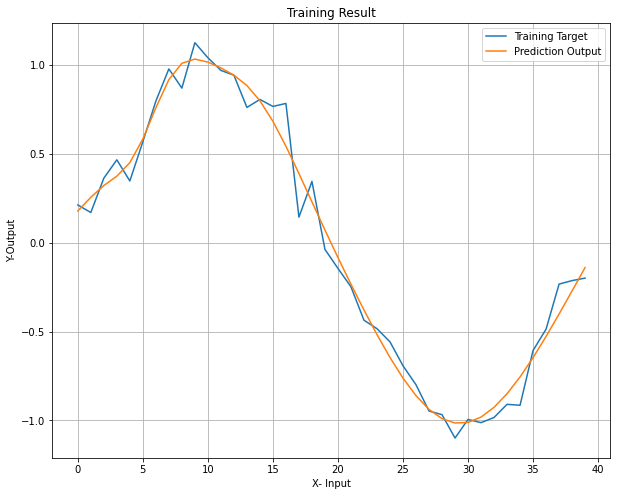

In [4]:
plt.figure(figsize=(10,8))
plt.plot(X.detach().numpy()[:,0],Y.detach().numpy()[:,0])
plt.plot(X.detach().numpy()[:,0],Ypred.detach().numpy()[:,0])
plt.legend(('Training Target', 'Prediction Output'))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Training Result')
plt.grid()

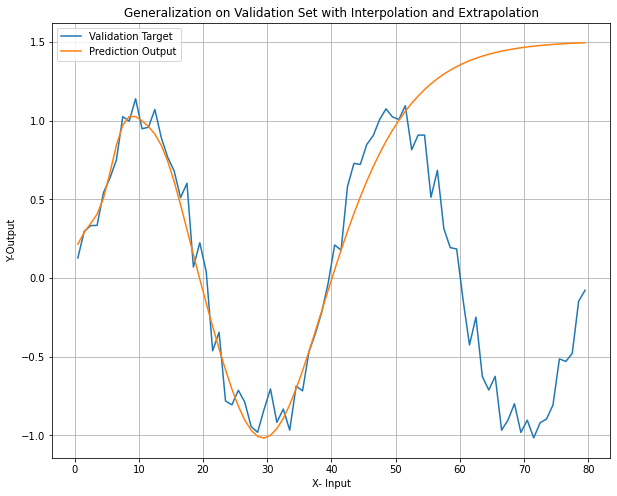

In [5]:
plt.figure(figsize=(10,8))
plt.plot(Xval.detach().numpy()[:,0],Yval.detach().numpy()[:,0])
plt.plot(Xval.detach().numpy()[:,0],Yvalpred.detach().numpy()[:,0])
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Generalization on Validation Set with Interpolation and Extrapolation')
plt.legend(('Validation Target', 'Prediction Output'))
plt.grid()

weights= OrderedDict([('layer1.0.weight', tensor([[-0.5088],
        [-0.2550],
        [ 0.4985],
        [ 0.2915],
        [ 0.1343],
        [ 0.2671],
        [-0.9076],
        [ 0.7294],
        [ 0.2727],
        [ 0.2595]])), ('layer1.0.bias', tensor([ 3.1945,  2.6750, -5.8499, -1.5089, -4.6306, -3.2002,  0.4955, -4.2299,
        -3.3864, -6.4529])), ('layer2.0.weight', tensor([[-0.7953,  1.5267,  2.0078, -1.2098,  4.8880, -1.6571, -0.6317,  1.5449,
         -1.3390, -2.8909]])), ('layer2.0.bias', tensor([0.1631]))])
model.state_dict()['layer2.0.weight']= tensor([[-0.7953,  1.5267,  2.0078, -1.2098,  4.8880, -1.6571, -0.6317,  1.5449,
         -1.3390, -2.8909]])


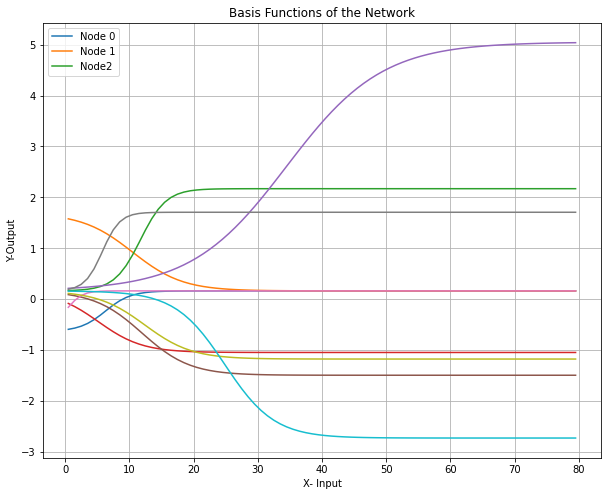

In [6]:
weights = model.state_dict()   #read obtained weights
print("weights=", weights)
#Weights of layer 2:
layer2weights=model.state_dict()['layer2.0.weight'].clone() #clone(), otherwise it is just a pointer!
print("model.state_dict()['layer2.0.weight']=", layer2weights)
   
#The resulting function from the network is the sum of the functions of the N nodes.
#To see the functions of the individual nodes, we can just keep their weight unchanged, 
#set the others to zero, and plot the resulting function.
#For that we make mask with zeros for the weights of layer 2, except for one node:

plt.figure(figsize=(10,8))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Basis Functions of the Network')

for node in range(0,Nodes):
    weightmask=torch.zeros(layer2weights.shape) #mask with all zeros for output layer, except one.
    weightmask[0,node]=1.0 #node "node" unchanged
    #print("weightmask",weightmask)
    #print("layer2weights=",layer2weights)
    #print("layer2weights*weightmask=", layer2weights*weightmask)
    model.state_dict()['layer2.0.weight'].data.copy_(layer2weights*weightmask) #write pytorch structure back to model
    #print("Xval=", Xval)
    Ypred1node=model(Xval) # Make Predictions based on the 1-node weights 
    #print("Ypred1node=", Ypred1node)
    #Plot modified 1-node model:
    plt.plot(Xval.detach().numpy()[:,0],Ypred1node.detach().numpy()[:,0])
plt.grid()      
plt.legend(('Node 0', 'Node 1', 'Node2'));
 #We see the activation function fit with bias and weight 
#to different parts of the target function

# Deep Function Approximator

In [8]:
N=40 #number of samples in our signal
Nodes=2 #Nodes in each layer
#Nodes=80  #this can result in over-fitting

#A multi-layer fully connected network, 1 input (time value), hidden layer has Nodes nodes, 1 output (function value).

class LinNet(nn.Module):
    #define and initialize the layers:
    def __init__(self):
        super(LinNet, self).__init__()
        # Define the model. 
        #https://pytorch.org/docs/stable/nn.html?highlight=linear#torch.nn.Linear  
        # Generate a fully connected linear neural network model, 2 layers, bias
        # returns: Trainable object
        self.layer1=nn.Sequential(nn.Linear(in_features=1, out_features=Nodes, bias=True))
        self.layer2=nn.Sequential(nn.Linear(in_features=Nodes, out_features=Nodes, bias=True))
        self.layer3=nn.Sequential(nn.Linear(in_features=Nodes, out_features=Nodes, bias=True))
        self.layer4=nn.Sequential(nn.Linear(in_features=Nodes, out_features=1, bias=True))
      
        #self.act = nn.LeakyReLU() #non-linear activation function
        #self.act = nn.ReLU() #non-linear activation function
        #self.act = nn.Hardtanh() #non-linear activation function
        self.act = nn.Sigmoid() #non-linear activation function
      
        #Putting the network together:
    def forward(self, x):
        out = self.layer1(x)
        #print("out.shape=", out.shape)
        out = self.act(out)  #comment out if not desired
        #print("out.shape=", out.shape)
        out = self.layer2(out)
        #print("out.shape=", out.shape)
        out = self.act(out)
        out = self.layer3(out)
        out = self.act(out)
        out = self.layer4(out)
        return out

In [9]:
print("Number of input samples:", N, "number of nodes:", Nodes)
#input tensor, type torch tensor:
#Indices: batch, additional dimensions, features or signal dimension. Here: 1 batch, 3 samples, signal dimension 2: 
#Training set:
#The x input here is the time:
X=torch.arange(0,N,1.0) #generates N time steps for X
X=X.view(N,1) #adding the last dimension for the signal (1 sample each), first dimension for the batch of size N
print("X.shape", X.shape)
#Target here is the (noisy) function value, a sine function + normal distributed random values:
#Y=torch.sin(X)+torch.empty(X.shape).normal_(std=0.5)
Y=torch.sin(X*3.14/N*2)+torch.randn(X.shape)*0.1
#2 periods of the sinusoid in our training set, plus noise
#Y=Y.view(N,1)
print("Y.shape", Y.shape)
#Validation set, to test generalization, with new noise:
Xval=torch.arange(0.5,2*N,1.0) #generates 2N time steps for X for extrapolation beyond N,
#shifted by 0.5 compared to training set, 
#for interpolation between the original sample points.
#print("Xval=", Xval)
Xval=Xval.view(2*N,1)
#Validation Target:
Yval=torch.sin(Xval*3.14/N*2)+torch.randn(Xval.shape)*0.1
#Yval=Yval.view(2*N,1)
   
#create network object:
model = LinNet().to(device)
#Before training:
Ypred=model(X) #the model produces prediction output
print("Ypred.shape=", Ypred.shape)
weights = model.state_dict()   #read obtained weights
print("initial weights=", weights)  #see the random initialization of the weights 
   
#print("model.parameters()=", model.parameters()) 
   
print("Define loss function:")
loss_fn = nn.MSELoss() #mean squared error loss
   
print("Define optimizer:")
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
print("Optimizing:")
for epoch in range(150000):
    Ypred=model(X) #the model produces prediction output
    loss=loss_fn(Ypred, Y) #prediction and target compared by loss
    if epoch%1000==0:
        print(epoch, loss.item()) #print current loss value
    optimizer.zero_grad() #optimizer sets previous gradients to zero
    loss.backward() #optimizer computes new gradients
    optimizer.step() #optimizer updates weights
       
Ypred=model(X) # Make Predictions based on the obtained weights 
#print("Ypred training set=", Ypred) 
loss=loss_fn(Ypred, Y)
print("Loss on trainig set:", loss.detach().numpy())

Number of input samples: 40 number of nodes: 2
X.shape torch.Size([40, 1])
Y.shape torch.Size([40, 1])
Ypred.shape= torch.Size([40, 1])
initial weights= OrderedDict([('layer1.0.weight', tensor([[-0.4129],
        [-0.6248]])), ('layer1.0.bias', tensor([ 0.9103, -0.4117])), ('layer2.0.weight', tensor([[ 0.5494, -0.3189],
        [-0.0651,  0.3223]])), ('layer2.0.bias', tensor([ 0.4558, -0.3586])), ('layer3.0.weight', tensor([[0.3642, 0.0567],
        [0.7016, 0.3529]])), ('layer3.0.bias', tensor([-0.3155,  0.0921])), ('layer4.0.weight', tensor([[ 0.5666, -0.0725]])), ('layer4.0.bias', tensor([0.6356]))])
Define loss function:
Define optimizer:
Optimizing:
0 1.2889302968978882
1000 0.5435008406639099
2000 0.5434579253196716
3000 0.5433863997459412
4000 0.5432174801826477
5000 0.0814628154039383
6000 0.042972538620233536
7000 0.04065283015370369
8000 0.039078883826732635
9000 0.038277316838502884
10000 0.037923507392406464
11000 0.03764687106013298
12000 0.03668951988220215
13000 0.035629

weights= OrderedDict([('layer1.0.weight', tensor([[-0.3619],
        [-2.1208]])), ('layer1.0.bias', tensor([10.7171,  3.4819])), ('layer2.0.weight', tensor([[-12.4110,   4.3027],
        [ -9.3968,  23.2823]])), ('layer2.0.bias', tensor([12.4153,  2.6586])), ('layer3.0.weight', tensor([[-8.2193,  3.5093],
        [27.1331,  9.0526]])), ('layer3.0.bias', tensor([  1.9730, -26.5862])), ('layer4.0.weight', tensor([[16.5843, -0.3417]])), ('layer4.0.bias', tensor([-0.8143]))])
model.state_dict()['layer2.0.weight']= tensor([[-12.4110,   4.3027],
        [ -9.3968,  23.2823]])


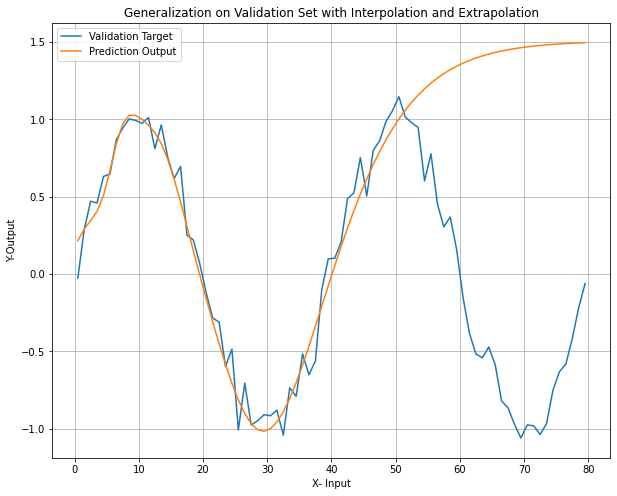

In [10]:
plt.figure(figsize=(10,8))
plt.plot(Xval.detach().numpy()[:,0],Yval.detach().numpy()[:,0])
plt.plot(Xval.detach().numpy()[:,0],Yvalpred.detach().numpy()[:,0])
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Generalization on Validation Set with Interpolation and Extrapolation')
plt.legend(('Validation Target', 'Prediction Output'))
plt.grid()
   
weights = model.state_dict()   #read obtained weights
print("weights=", weights)
#Weights of layer 2:
layer2weights=model.state_dict()['layer2.0.weight'].clone() #clone(), otherwise it is just a pointer!
print("model.state_dict()['layer2.0.weight']=", layer2weights)

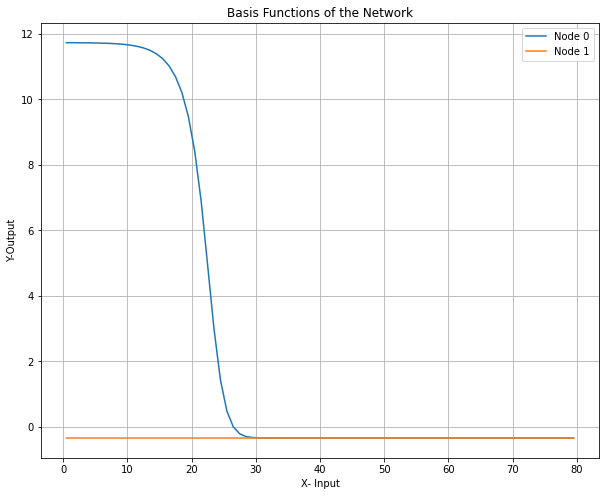

In [11]:
#The resulting function from the network is the sum of the functions of the N nodes.
#To see the functions of the individual nodes, we can just keep their weight unchanged, 
#set the others to zero, and plot the resulting function.
#For that we make mask with zeros for the weights of layer 2, except for one node:

plt.figure(figsize=(10,8))
plt.xlabel('X- Input')
plt.ylabel('Y-Output')
plt.title('Basis Functions of the Network')
for node in range(0,Nodes):
    weightmask=torch.zeros(layer2weights.shape) #mask with all zeros for output layer, except one.
    weightmask[0,node]=1.0 #node "node" unchanged
    #print("weightmask",weightmask)
    #print("layer2weights=",layer2weights)
    #print("layer2weights*weightmask=", layer2weights*weightmask)
    model.state_dict()['layer2.0.weight'].data.copy_(layer2weights*weightmask) #write pytorch structure back to model
    #print("Xval=", Xval)
    Ypred1node=model(Xval) # Make Predictions based on the 1-node weights 
    #print("Ypred1node=", Ypred1node)
    #Plot modified 1-node model:
    plt.plot(Xval.detach().numpy()[:,0],Ypred1node.detach().numpy()[:,0])
      
#plt.legend(('Validation Target', 'Prediction Output', 'Node 0', 'Node 5'))
plt.legend(('Node 0', 'Node 1', 'Node2'))
plt.grid()
#We see the activation function fit with bias and weight 
#to different parts of the target function